In [1]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 12})
mpl.rcParams['axes.formatter.useoffset'] = False

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import LinearLocator, LogLocator, MaxNLocator, FormatStrFormatter
import numpy as np
import copy
from cmcrameri import cm

In [2]:
import utils.load_grid as lg
from proteus.config import read_config

### Read data

In [3]:
pgrid_dir = "data/output/NOH_d/"
cases = lg.get_cases(pgrid_dir)
ncases = len(cases)

In [4]:
# Case numbers
cnums = ["%d"%int(s.split("_")[-1]) for s in cases]

In [5]:
stts = lg.get_statuses(pgrid_dir)

# Helpfiles
helps, hvars = lg.load_helpfiles(cases)


# Configuration variables
conf = []
for f in cases:
    conf.append( read_config(f+"/init_coupler.toml") )

print("Done")

Helpfiles: 100%|██████████| 100/100 [00:02<00:00, 43.34it/s]


Done


In [6]:
solid_thresh = float(lg.descend_get(conf[0],"params.stop.solid.phi_crit"))*1.01
print("Solidification threshold = %.3f%%"%(solid_thresh*100))

Solidification threshold = 2.020%


In [7]:
# %matplotlib widget

%matplotlib inline
# %config InlineBackend.figure_format='retina'

### Function to plot z vs x,y scatter graphs

In [17]:
def make_s2d(x,x_lbl, y,y_lbl, z,z_lbl, control,
             title="", figscale=1.0, show_cbar=True,
             plot_scatter=True, plot_casenums=False, plot_controls=False,
             xscale="linear", xmult=1.0,
             yscale="linear",ymult=1.0, fmt_cbar="%g", marker_s = 100,
             zscale="linear", zmult=1.0, minz=None, maxz=None,
             interp='none', hatch_solid=False, symmetric=False, extend='both'):

    # Plotting parameters
    norm_lev = 11       # contour levels
    marker_e = 'none'   # scatter edge color
    hatch_c  = 'white'  # hatch color
    hatch_t  = '//'      # hatch type
    hatch_w  = 1.0      # hatch line width

    # Check params
    if symmetric and (zscale == "log"):
        print("WARNING: Cannot do symmetric colour-mapping with log-norm")
        return

    # Gather the data
    print("Gather data")
    x_plt = np.array([], dtype=float) # x variable
    y_plt = np.array([], dtype=float) # y variable
    z_plt = np.array([], dtype=float) # z variable
    h_plt = np.array([], dtype=float) # hatch variable (i.e. melt fraction)
    c_plt = np.array([], dtype=str)   # case number
    g_plt = np.array([], dtype=bool)  # case finished with success? (good)
    for i in range(ncases):
        keep_this = True
        for k in control.keys():
            if not (lg.descend_get(conf[i],k) == control[k]):
                keep_this = False
        if not keep_this:
            continue

        cn = cnums[i]

        # duplicates?
        this_x =  lg.descend_get(conf[i],x)
        this_y = lg.descend_get(conf[i],y)
        for j in range(len(x_plt)):
            if np.isclose(this_x, x_plt[j]) and np.isclose(this_y, y_plt[j]):
                print("WARNING: Duplicate point added to array (case=%s, x=%g, y=%g)"%(cn, this_x, this_y))

        # add point
        x_plt = np.append(x_plt, xmult*this_x)
        y_plt = np.append(y_plt, ymult*this_y)
        z_plt = np.append(z_plt, zmult*lg.access_hvars(hvars, z, -1)[i])
        h_plt = np.append(h_plt, lg.access_hvars(hvars, "Phi_global", -1)[i])
        c_plt = np.append(c_plt, cn)
        g_plt = np.append(g_plt, bool( 10 <= stts[i] <= 19))
    if len(z_plt) == 0:
        print("WARNING: No data left after applying control variables!")
        return
    b_plt = np.invert(g_plt)

    print("shape x:",np.shape(x_plt))
    print("shape y:",np.shape(y_plt))
    print("shape z:",np.shape(z_plt))

    # Do interpolation on z-variable
    interp_npts = 40
    interp = interp.lower().strip()
    do_interp = interp in ['contour', 'mesh']
    if do_interp:
        print("Interpolate z")
        marker_e='white'

        _,_,xxi,yyi,zzi = lg.interp_2d(x_plt,y_plt,z_plt, interp_npts, method='linear')

    # Hatch solid cases (if allowing interpolation)
    hatch_solid = hatch_solid and do_interp
    if hatch_solid:
        print("Interpolate phi")
        _,_,_,_,hhi = lg.interp_2d(x_plt, y_plt,h_plt, interp_npts, method='linear')

    # Colour mapping
    if minz == None:
        minz = np.amin(z_plt)
    if maxz == None:
        maxz = np.amax(z_plt)
    if abs(minz-maxz) < 1.0e-20:
        print("ERROR: minz and maxz are the same")
        return
    if minz > maxz:
        minz, maxz = maxz, minz
    if (zscale == "linear"):
        if symmetric:
            maxz = max(maxz, abs(minz))
            minz = -1.0 * maxz
        norm = mpl.colors.Normalize(vmin=minz, vmax=maxz)
        levels = np.linspace(minz, maxz, norm_lev)
    else:
        norm = mpl.colors.LogNorm(vmin=minz, vmax=maxz)
        levels = norm_lev
        # levels = np.logspace(np.log10(minz), np.log10(maxz), norm_lev)

    if symmetric:
        cmap = copy.deepcopy(cm.roma)
    else:
        cmap = copy.deepcopy(cm.batlow)
        cmap.set_under('deepskyblue')
        cmap.set_over('crimson')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    mappable = sm # mappable for colorbar

    # Make the plot
    print("Plot")
    fig,ax = plt.subplots(1,1, figsize=(5*figscale,4*figscale))

    #    plot interpolation
    if do_interp:
        zzi = np.clip(zzi, minz*(1+1.0e-10), maxz*(1-1.0e-10))  # avoid numerical artifacts from interpolation + cmapping
        match interp:
            case 'scatter':
                ax.scatter(xxi, yyi, c=zzi,  cmap=cmap, norm=norm,)
            case 'contour':
                mappable = ax.contourf(xxi,yyi,zzi, cmap=cmap, norm=norm, levels=levels, vmin=minz, vmax=maxz)
            case 'mesh':
                ax.pcolormesh(xxi,yyi,zzi, cmap=cmap, norm=norm)

    #    plot hatches
    if hatch_solid:
        mpl.rcParams['hatch.linewidth'] = hatch_w
        mpl.rcParams['hatch.color'] = hatch_c
        if np.any(hhi <= solid_thresh):
            # contour hatches
            ax.contourf(xxi,yyi,hhi, alpha=0.0, levels=[-1,solid_thresh,1],hatches=[hatch_t,''], zorder=3, extend='upper')
            # contour boundary
            ax.contour( xxi,yyi,hhi, alpha=1.0, levels=[-1,solid_thresh,1],colors=[hatch_c]*3, zorder=3, extend='upper',linewidths=[hatch_w]*3)

    #    plot the raw values
    if plot_scatter:
        ax.scatter(x_plt[g_plt], y_plt[g_plt], c=z_plt[g_plt], norm=norm, cmap=cmap, marker='s', s=marker_s, edgecolors=marker_e, zorder=4)
        ax.scatter(x_plt[b_plt], y_plt[b_plt], c=z_plt[b_plt], norm=norm, cmap=cmap, marker='o', s=marker_s, edgecolors='k', zorder=4, linestyle='dotted')

    #    plot case numbers (debugging)
    if plot_casenums:
        for i in range(len(x_plt)):
            ax.text(x_plt[i],y_plt[i],c_plt[i],fontsize=7, color='white', horizontalalignment='center', verticalalignment='center', zorder=10)

    #    plot control variable text box (debugging)
    if plot_controls:
        control_str = "Control variables:\n"
        for k in control.keys():
            control_str += "  %s=%g\n" % (k,control[k])
        control_str = control_str[:-1]
        axt = ax.text(0.05, 0.95, control_str, zorder=12,
                horizontalalignment='left', verticalalignment='top', transform=ax.transAxes, fontsize=10)
        axt.set_bbox(dict(facecolor='white', alpha=0.5, linewidth=0))

    #    colorbar
    if show_cbar:
        cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05)
        cbar = fig.colorbar(mappable, cax=cax, orientation='vertical',  extend=extend)
        cbar.set_label(z_lbl)
        cbar.ax.yaxis.set_major_formatter(FormatStrFormatter(fmt_cbar))


    #    finalise
    ax.set_xlabel(x_lbl)
    ax.set_ylabel(y_lbl)
    if (title != None) and (len(title) > 0):
        ax.set_title(title)

    if xscale == "symlog":
        ax.set_xscale(xscale, linthresh=np.amin(x_plt[x_plt>0]))
    else:
        ax.set_xscale(xscale)

    if yscale == "symlog":
        ax.set_yscale(yscale, linthresh=np.amin(y_plt[y_plt>0]))
    else:
        ax.set_yscale(yscale)

    return fig,ax

Gather data
shape x: (100,)
shape y: (100,)
shape z: (100,)
Plot


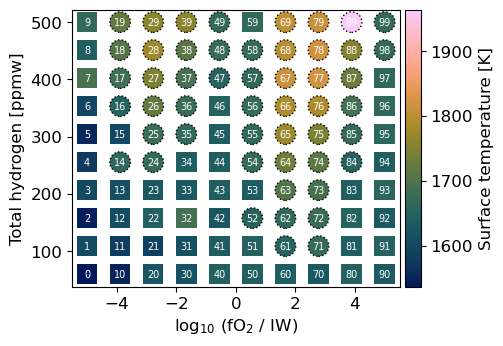

data/output/NOH_d/


In [19]:
# -----------
# Reset
plt.close("all")
minz, maxz = None, None
xmult, ymult, zmult = 1.0, 1.0, 1.0
extend = "neither"
title = ""
fmt_cbar = "%g"
control = {}
marker_s = 220

# -----------
# Variables

x = "outgas.fO2_shift_IW";  x_lbl = "log$_{10}$ (fO$_{2}$ / IW)"; xscale="linear"
# x = "delivery.elements.H_ppmw";   x_lbl = "Hydrogen [ppmw]"; xscale="linear"

y = "delivery.elements.H_ppmw";   y_lbl = "Total hydrogen [ppmw]"; yscale="linear"
# y = "orbit.dummy.H_tide";   y_lbl = "$H_{tide}$ [W kg$^{-1}$]"; yscale="symlog"

# control["orbit.dummy.H_tide"] = 0.0
# control["delivery.elements.H_ppmw"] = 100.0
# control["outgas.fO2_shift_IW"] = 0


z = "T_surf"; z_lbl = "Surface temperature [K]"; zscale="linear"; fmt_cbar = "%d"
# z = "Phi_global"; z_lbl = "Melt fraction [%]"; zscale="linear"; zmult=100; minz=0; maxz=100; extend='min'
# z = "Time"; z_lbl = "Time [Myr]"; zmult=1e-6; zscale="linear"; minz=10; fmt_cbar="%d"
# z = "F_tidal"; z_lbl = r"Tidal heat flux [W m$^{-2}$]"; zscale="linear"
# z = "transit_depth"; z_lbl = r"Transit depth [ppm]"; zscale="linear"; zmult=1e6; fmt_cbar="%d"
# z = "contrast_ratio"; z_lbl = r"Contrast ratio [ppm]"; zscale="linear"; zmult=1e6; fmt_cbar="%.1f"

# -----------
# Make plot
plot_controls = False
plot_casenums = True
plot_scatter  = True
hatch_solid   = True
figscale      = 0.9
show_cbar     = True
interp        = 'none'
outpath       = "output/recent_s2d.pdf"

fig,ax = make_s2d(x,x_lbl, y,y_lbl, z,z_lbl, control, title=title,
         plot_scatter=plot_scatter,plot_casenums=plot_casenums, plot_controls=plot_controls,
         xscale=xscale, xmult=xmult,
         yscale=yscale, ymult=ymult,
         zscale=zscale, zmult=zmult, minz=minz, maxz=maxz,
         show_cbar=show_cbar, fmt_cbar=fmt_cbar, marker_s=marker_s,
         interp=interp, hatch_solid=hatch_solid, figscale=figscale, extend=extend
         )

fig.savefig(outpath, bbox_inches='tight')
plt.show()

print(pgrid_dir)